In [71]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import json
import seaborn as sns

import math
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pytz
# from datetime import datetime
import datetime
import time

import collections
from wordcloud import WordCloud

In [72]:
import settings
import mysql.connector
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly
import random
import plotly.express as px
from IPython.display import clear_output
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
py.init_notebook_mode()

In [73]:
# Filter constants for states in US
STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'American Samoa', 'AS', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', 'Delaware', 'DE', 'District of Columbia', 'DC', 'Federated States of Micronesia', 'FM', 'Florida', 'FL', 'Georgia', 'GA', 'Guam', 'GU', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', 'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Marshall Islands', 'MH', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Northern Mariana Islands', 'MP', 'Ohio', 'OH', 'Oklahoma', 'OK', 'Oregon', 'OR', 'Palau', 'PW', 'Pennsylvania', 'PA', 'Puerto Rico', 'PR', 'Rhode Island', 'RI', 'South Carolina', 'SC', 'South Dakota', 'SD', 'Tennessee', 'TN', 'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virgin Islands', 'VI', 'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY']
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())

In [74]:
# Read json data containing tweets
# tweets_data_path = 'elite.json'

# with open(tweets_data_path) as f:
#   tweets_data = json.load(f)
# print("The total number of Tweets is:",len(tweets_data))
# import pprint
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(tweets_data[0])
# # Convert json to dataframe
# tweets_df = pd.read_json(tweets_data_path, orient='columns')

In [75]:
db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="password",
    database="TwitterDB",
    charset = 'utf8'
)
TABLE_NAME = "elite"
# Load data from MySQL
# timenow = (datetime.datetime.utcnow() - datetime.timedelta(hours=0, minutes=30)).strftime('%Y-%m-%d %H:%M:%S')
# query = "SELECT * FROM {} WHERE created_at >= '{}' ".format(TABLE_NAME, timenow)
query = "SELECT * FROM {} ".format(TABLE_NAME)
tweets_df = pd.read_sql(query, con=db_connection)

In [76]:
tweets_df.head()

id          created_at               id_str  \
0  35 2020-03-16 23:30:20  1239695526045650949   
1  36 2020-03-16 23:30:34  1239695585143164928   
2  37 2020-03-16 23:30:41  1239695613232656390   
3  38 2020-03-16 23:30:43  1239695621583523841   
4  39 2020-03-16 23:30:44  1239695627719770117   

                                                text   in_reply_to  \
0  RT @realmmarshall1: All new Road To!  We’ll se...                 
1  @SportsCenter @WWE Bruh these days it can be 2...  SportsCenter   
2  RT @CodyRhodes: Brand new #aew “Road To...” to...                 
3  RT @sammyguevara: ? you got a friend in me, yo...                 
4  RT @AEWrestling: Can the #BestFriends gain the...                 

        user_name       user_location  \
0  EricBuffalo316          Amherst NY   
1   TheRealRalphC                       
2    Jayystackks1       New York, USA   
3  Wwe_queenbeast          Texas, USA   
4  EricMoreno6477  San Antonio, Texas   

                                    user_description        user_created geo  \
0  35 big pro wrestling fan; AEW Wrestling rules;... 2012-07-03 06:29:42       
1                                       MambaForever 2012-03-12 02:09:35       
2  MEDIA BlOG for for ProWrestling.@wwenxt. @AEWr... 2018-08-13 21:02:43       
3              I’m a hardcore wwe fan and love anime 2019-10-28 00:52:22       
4  I read, I write, I travel – I live my life the... 2010-03-11 16:45:15       

  coordinates  user_followers_count  user_friends_count  retweet_count  \
0                               169                 772              0   
1                                71                  58              0   
2                                78                 470              0   
3                                47                 348              0   
4                              1003                4373              0   

   favorites_count  polarity  subjectivity  
0                0  0.170455      0.454545  
1                0  0.000000      0.000000  
2                0  0.170455      0.454545  
3                0  0.625000      0.500000  
4                0  0.000000      0.000000

In [77]:
#tweets_df.head()
tweets_df['in_reply_to'] = tweets_df['in_reply_to'].apply(lambda i : i or '')

In [78]:
tweets_df['text'] = tweets_df['text'].apply(lambda text: text.encode('ascii', 'ignore').decode('ascii'))

In [79]:
# add column is_retweet 
tweets_df['is_retweet'] = tweets_df['text'].apply(lambda x: False if 'RT' not in x else True)

In [80]:
# convert created_at and user_created time to CST
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], format = '%Y-%m-%d %H:%M:%S')
tweets_df['created_at'] = tweets_df['created_at'].dt.tz_localize('utc')
tweets_df['created_at'] = tweets_df['created_at'].dt.tz_convert('US/Central')
tweets_df['user_created'] = pd.to_datetime(tweets_df['user_created'], format = '%Y-%m-%d %H:%M:%S')
tweets_df['user_created'] = tweets_df['user_created'].dt.tz_localize('utc')
tweets_df['user_created'] = tweets_df['user_created'].dt.tz_convert('US/Central')
tweets_df.tail()

id                created_at               id_str  \
1429  1480 2020-03-16 23:54:00-05:00  1239776978481188864   
1430  1481 2020-03-16 23:54:25-05:00  1239777084282716161   
1431  1482 2020-03-16 23:54:50-05:00  1239777190675431426   
1432  1483 2020-03-16 23:55:03-05:00  1239777243326447621   
1433  1484 2020-03-16 23:55:25-05:00  1239777334712033281   

                                                   text in_reply_to  \
1429  #Burrra #wwe #wrestling #raw #nxt #smackdown #...               
1430  RT @WrestlingIMB: #RAW #AEWDynamite #WWENXT #S...               
1431  RT @orangecassidy: Never met Stone Cold, proba...               
1432  RT @ShutUpExcalibur: If you're looking for wre...               
1433  RT @_GiannaCozzoli_: My mom asked me what kind...               

            user_name         user_location  \
1429   burrraofficial                         
1430          AWN_hub            Dallas, TX   
1431   AmericanSeed76                   USA   
1432  UnimPhenomenous    From Parts Unknown   
1433      ReneeSteel3  Up Colby Brock's ass   

                                       user_description  \
1429  Burrra is a simple way to capture and share th...   
1430  All Wrestling News platform!!! We talk about w...   
1431  God, Country, and Sports. I also like comedy. ...   
1432  Rising tides lift all ships, so Toot Toot! ⛵\n...   
1433  Pansexual ?\nSupernatural Idgit\nYoutube-renee...   

                  user_created geo coordinates  user_followers_count  \
1429 2012-02-24 02:27:30-06:00                                     9   
1430 2019-06-20 23:43:19-05:00                                   718   
1431 2017-07-18 19:19:29-05:00                                   384   
1432 2018-07-13 14:22:32-05:00                                   222   
1433 2018-02-12 18:24:20-06:00                                   348   

      user_friends_count  retweet_count  favorites_count  polarity  \
1429                   3              0                0 -0.230769   
1430                2211              0                0 -0.230769   
1431                1150              0                0 -0.600000   
1432                2055              0                0 -0.150000   
1433                1223              0                0  0.600000   

      subjectivity  is_retweet  
1429      0.461538       False  
1430      0.461538        True  
1431      1.000000        True  
1432      0.400000        True  
1433      0.466667        True

In [81]:
tweets_df['sentiment'] = tweets_df['polarity'].apply(lambda x: -1 if x < 0 else ( 1 if x > 0 else 0) )

In [82]:
tweets_df.sort_values(by=['retweet_count'], ascending=True)

id                created_at               id_str  \
0       35 2020-03-16 18:30:20-05:00  1239695526045650949   
960   1009 2020-03-16 21:22:12-05:00  1239738779193278464   
959   1008 2020-03-16 21:22:02-05:00  1239738737178877953   
958   1007 2020-03-16 21:21:57-05:00  1239738716547174408   
957   1006 2020-03-16 21:21:57-05:00  1239738714512818176   
...    ...                       ...                  ...   
474    519 2020-03-16 19:57:04-05:00  1239717352075227138   
473    518 2020-03-16 19:56:45-05:00  1239717272945487877   
472    517 2020-03-16 19:56:38-05:00  1239717245976219648   
492    537 2020-03-16 20:00:29-05:00  1239718215061823488   
1433  1484 2020-03-16 23:55:25-05:00  1239777334712033281   

                                                   text in_reply_to  \
0     RT @realmmarshall1: All new Road To!  Well see...               
960   RT @BeaPriestley: I didnt travel half way acro...               
959   RT @AEWrestling: .@BeaPriestley made her inten...               
958   RT @orangecassidy: Never met Stone Cold, proba...               
957   Meanwhile, AEW should also become a temporary ...               
...                                                 ...         ...   
474   #Burrra #wwe #wrestling #raw #nxt #smackdown #...               
473   RT @AEWrestling: After weeks of taunting, the ...               
472   RT @AEWrestling: Staying in?\nCatch up on the ...               
492   RT @MrAWESOME2477: @ValiantSaint @LanceHoyt @i...               
1433  RT @_GiannaCozzoli_: My mom asked me what kind...               

            user_name           user_location  \
0      EricBuffalo316              Amherst NY   
960      VillainBurai         Destiny Islands   
959      VillainBurai         Destiny Islands   
958      MarquisGunnn                           
957          neio_geo                           
...               ...                     ...   
474    burrraofficial                           
473      FrankBarreta                           
472   Karma_Kills_836  Camp Crystal Lake ////   
492   PimpSlapYaPcLip                           
1433      ReneeSteel3    Up Colby Brock's ass   

                                       user_description  \
0     35 big pro wrestling fan; AEW Wrestling rules;...   
960   Video Games, Anime, Manga, Wrestling. These ma...   
959   Video Games, Anime, Manga, Wrestling. These ma...   
958                                                       
957   Film Psychology, Videogames, Pro Wrestling, an...   
...                                                 ...   
474   Burrra is a simple way to capture and share th...   
473                 Smile, because it confuses people..   
472   We are The Karma Demon ...We likes Fun stuff l...   
492                                                       
1433  Pansexual ?\nSupernatural Idgit\nYoutube-renee...   

                  user_created geo coordinates  user_followers_count  \
0    2012-07-03 01:29:42-05:00                                   169   
960  2018-11-07 08:12:21-06:00                                    16   
959  2018-11-07 08:12:21-06:00                                    16   
958  2017-07-13 11:49:03-05:00                                    51   
957  2011-02-22 15:02:02-06:00                                  1884   
...                        ...  ..         ...                   ...   
474  2012-02-24 02:27:30-06:00                                     9   
473  2019-03-04 19:18:22-06:00                                    34   
472  2014-02-08 13:40:01-06:00                                   979   
492  2017-04-21 16:48:05-05:00                                  1124   
1433 2018-02-12 18:24:20-06:00                                   348   

      user_friends_count  retweet_count  favorites_count  polarity  \
0                    772              0                0  0.170455   
960                  977              0                0 -0.166667   
959                  977              0          

In [83]:
# Compute # of RT's, @'s, and text tweets
retweet_tweets = tweets_df[tweets_df['is_retweet'] == True]
response_tweets = tweets_df[tweets_df['in_reply_to']!='']
mention_tweets = tweets_df[~tweets_df['text'].str.contains("RT")  & tweets_df['text'].str.contains("@")]
mention_tweets = mention_tweets[mention_tweets['in_reply_to']==""]
text_tweets = tweets_df[~tweets_df['text'].str.contains("@")  & ~tweets_df['text'].str.contains("RT")]
url_tweets = tweets_df[tweets_df['text'].str.contains("http")]

print("Total number of tweets:", len(tweets_df))
print("Total number of retweets:", len(retweet_tweets))
print("Total number of response tweets:", len(response_tweets))
print("Total number of tweets with mentions that are not retweets or responses:", len(mention_tweets))
print("Total number of text tweets:", len(text_tweets))
print("Number of tweets containing URL links:", len(url_tweets))
print("Number of different users:", tweets_df['user_name'].nunique())
print("Number of tweets per user:", len(tweets_df)/tweets_df['user_name'].nunique())

Total number of tweets: 1434
Total number of retweets: 1040
Total number of response tweets: 82
Total number of tweets with mentions that are not retweets or responses: 79
Total number of text tweets: 237
Number of tweets containing URL links: 419
Number of different users: 1042
Number of tweets per user: 1.3761996161228407


In [84]:
values = [ len(retweet_tweets), len(response_tweets), len(mention_tweets), len(text_tweets)]
labels = ['Retweets', 'Responses', 'Mentions', 'Text tweets']
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(
    title_text = 'Percentage of Tweets by Type'
)
fig.show()

In [85]:
# Find most used hashtags
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(tweets_df['text'].apply(hashtag_pattern.findall))
hashtag_words = []
for match in hashtag_matches:
    for word in match:
        hashtag_words.append(word.lower())

In [86]:
# hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1])
# hashtag_ordered_list = hashtag_ordered_list[::-1]
# hashtag_ordered_values = []
# hashtag_ordered_keys = []
# for item in hashtag_ordered_list[0:50]:
#     hashtag_ordered_keys.append(item[0])
#     hashtag_ordered_values.append(item[1])

In [87]:
# fig, ax = plt.subplots(figsize = (12,12))
# y_pos = np.arange(len(hashtag_ordered_keys))
# ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = 'green', edgecolor = 'black', linewidth=1)
# ax.set_yticks(y_pos)
# ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
# ax.set_xlabel("Nº of appereances")
# ax.set_title("Most used #hashtags", fontsize = 20)
# plt.tight_layout(pad=3)
# plt.show()
fdist = FreqDist(hashtag_words)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Word","Frequency"]).reindex()
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
fig = go.Figure(trace)
fig.update_layout(
    title="Most Frequently Used Hashtags",
    xaxis_title="Hashtags",
    yaxis_title="Frequency",
)
fig.show()

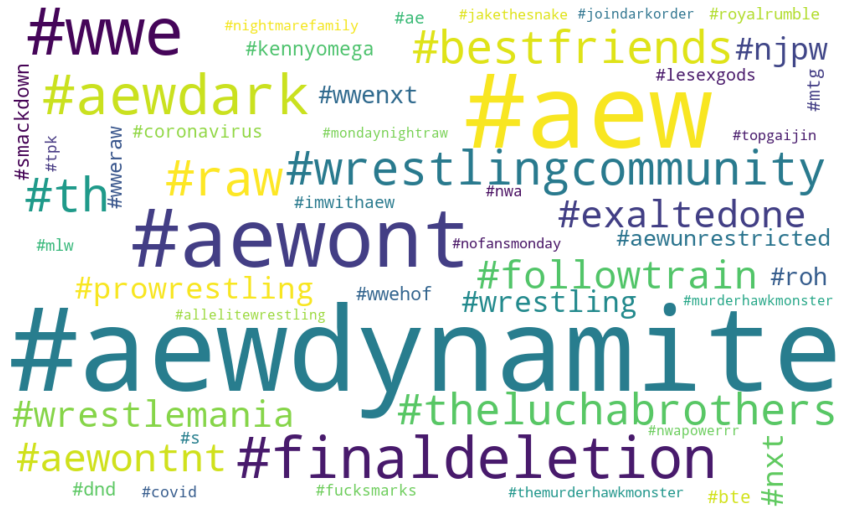

In [88]:
#Make a wordcloud plot of the most used hashtags
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [89]:
# Find most mentioned accounts
mentions = []
mention_pattern = re.compile(r"@[a-zA-Z_]+")
mention_matches = list(tweets_df['text'].apply(mention_pattern.findall))
mentioned_accounts = []
for match in mention_matches:
    for word in match:
        mentioned_accounts.append(word.lower())

In [90]:
fdist = FreqDist(mentioned_accounts)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Word","Frequency"])
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
fig = go.Figure(trace)
fig.update_layout(
    title="Most Mentioned Accounts",
    xaxis_title="Username",
    yaxis_title="Frequency",
)
fig.show()

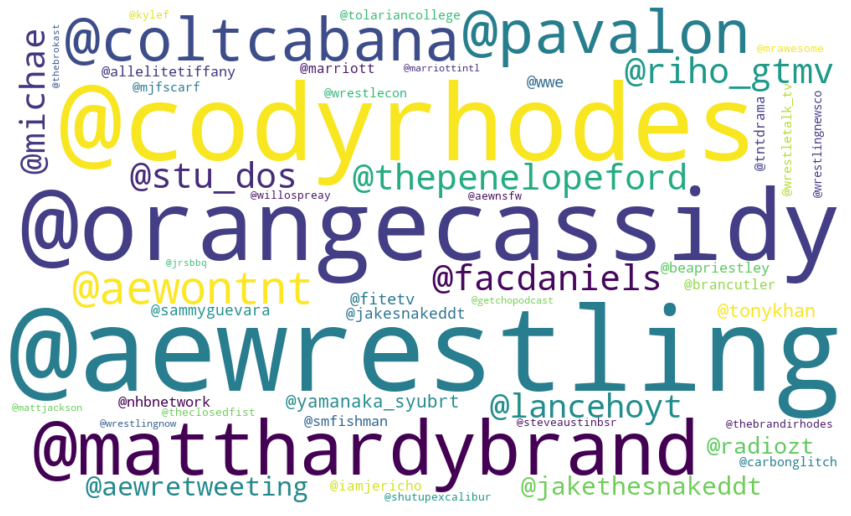

In [91]:
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [92]:
words = []
words_filtered = []
words = ' '.join(tweets_df["text"])
words = re.sub(r"http\S+", "", words)
words = words.replace('RT ', ' ').replace('&amp;', 'and')
words = re.sub('[^A-Za-z0-9]+', ' ', words)
words = words.lower()
tokenized_words = word_tokenize(words)
stopword_list=set(stopwords.words("english"))
#stopword_list.add("")
for word in tokenized_words:
    if word not in stopword_list:
        if "@"+word not in mentioned_accounts:#exclude accounts
            if "#"+word not in hashtag_words:#exclude hashtags
                words_filtered.append(word)


In [93]:
fdist = FreqDist(words_filtered)
fd = pd.DataFrame(fdist.most_common(50), columns = ["Word","Frequency"])#.drop([0]).reindex()
trace = go.Bar(x=fd["Word"], y=fd["Frequency"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
fig = go.Figure(trace)
fig.update_layout(
    title="Most Frequently Words (excluding hashtags and usernames)",
    xaxis_title="Words",
    yaxis_title="Frequency",
)
fig.show()

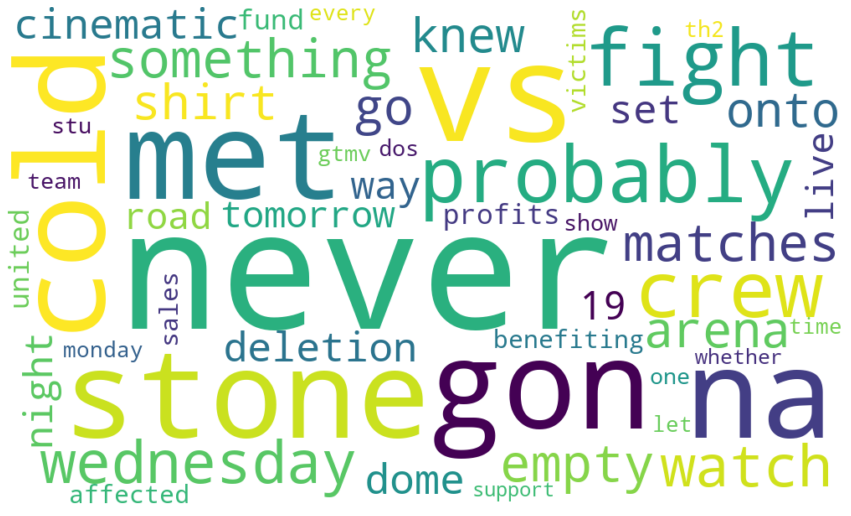

In [94]:
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [95]:
is_in_US=[]
geo = tweets_df[['user_location']]
tweets_df = tweets_df.fillna(" ")
for x in tweets_df['user_location']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(None)
is_in_US
geo_dist = pd.DataFrame(is_in_US, columns=['State']).dropna().reset_index()
geo_dist = geo_dist.groupby('State').count().rename(columns={"index": "Number"}) \
        .sort_values(by=['Number'], ascending=False).reset_index()
geo_dist["Log Num"] = geo_dist["Number"].apply(lambda x: math.log(x, 2))
geo_dist['Full State Name'] = geo_dist['State'].apply(lambda x: INV_STATE_DICT[x])
geo_dist['text'] = geo_dist['Full State Name'] + '<br>' + 'Num: ' + geo_dist['Number'].astype(str)

fig = go.Figure(data=go.Choropleth(
    locations=geo_dist['State'], # Spatial coordinates
    z = geo_dist['Number'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Number of tweets",
))
fig.update_layout(
    title_text = 'Tweets by User Location',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

In [96]:
# Time series
total = tweets_df.groupby(pd.Grouper(key='created_at', freq='10min')).count().reset_index()
total = total.rename(columns={"user_name": "Num of tweets", "created_at":"Time in CST"})  
time_series = total["Time in CST"].reset_index(drop=True)
result = tweets_df.groupby([pd.Grouper(key='created_at', freq='10min'), 'sentiment']).count().unstack(fill_value=0).stack().reset_index()
result = result.rename(columns={"user_name": "Num of tweets", "created_at":"Time in CST"})  
time_series_ = result["Time in CST"][result['sentiment']==0].reset_index(drop=True)

In [97]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time_series,
    y=total["Num of tweets"],
    name="Total",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['sentiment']==0].reset_index(drop=True),
    name="Neural",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['sentiment']<0].reset_index(drop=True),
    name="Negative",
    opacity=0.8))
fig.add_trace(go.Scatter(
    x=time_series,
    y=result["Num of tweets"][result['sentiment']>0].reset_index(drop=True),
    name="Positive",
    opacity=0.8))

fig.update_layout(
    title="Number of Tweets over time (and sentiment of Tweets)",
    xaxis_title="Time in CST",
    yaxis_title="Frequency",
)
fig.show()


In [98]:
print("There are {} different users".format(tweets_df['user_name'].nunique()))

There are 1042 different users


In [99]:
user_tweets = tweets_df.groupby('user_name').count()
user_tweets = user_tweets.rename(columns={"text":"count"}).reset_index()
user_tweets.head()

user_name  id  created_at  id_str  count  in_reply_to  user_location  \
0    1984_Huxley   4           4       4      4            4              4   
1   19Phranchize   1           1       1      1            1              1   
2   215Wrestling   1           1       1      1            1              1   
3  23_Revelation   3           3       3      3            3              3   
4       3000Dojo   1           1       1      1            1              1   

   user_description  user_created  geo  coordinates  user_followers_count  \
0                 4             4    4            4                     4   
1                 1             1    1            1                     1   
2                 1             1    1            1                     1   
3                 3             3    3            3                     3   
4                 1             1    1            1                     1   

   user_friends_count  retweet_count  favorites_count  polarity  subjectivity  \
0                   4              4                4         4             4   
1                   1              1                1         1             1   
2                   1              1                1         1             1   
3                   3              3                3         3             3   
4                   1              1                1         1             1   

   is_retweet  sentiment  
0           4          4  
1           1          1  
2           1          1  
3           3          3  
4           1          1

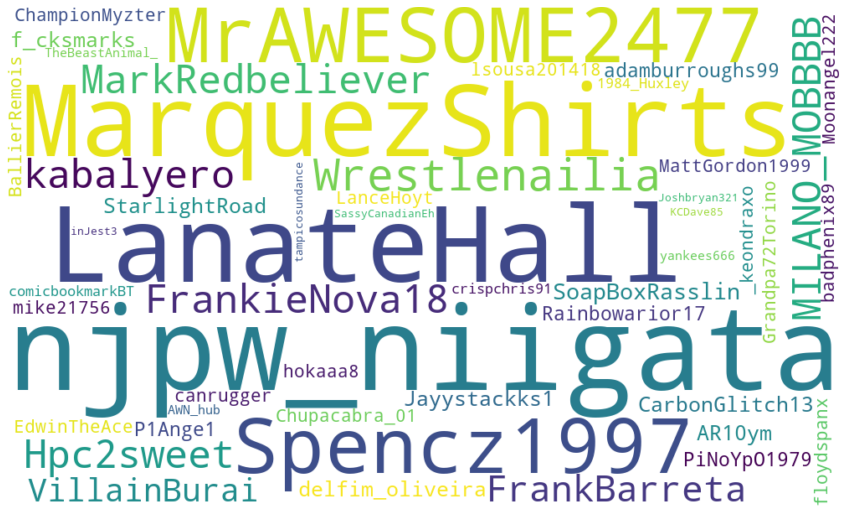

In [100]:
# Top 50 users with most tweets
fd = user_tweets[["user_name","count"]].sort_values(by=['count'], ascending=False).head(50)
# trace = go.Bar(x=fd["user_name"], y=fd["count"], name="Freq Dist")
# data = [trace]
# py.iplot(data)
#Make a wordcloud representation
tuples = [tuple(x) for x in fd.values]
wordcloud = WordCloud(width=1000, height=600, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(dict(tuples))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()